In [1]:
import os 
import glob 

import numpy as np 
import pandas as pd
import MDAnalysis as mda
import matplotlib.pyplot as plt 

from MDAnalysis.analysis import distances

%run ~/.mpl_set.py

In [2]:
runs = glob.glob("../../md_runs/run_*")
runs

['../../md_runs/run_187',
 '../../md_runs/run_pep',
 '../../md_runs/run_protein',
 '../../md_runs/run_mas',
 '../../md_runs/run_zz32',
 '../../md_runs/run_zz4',
 '../../md_runs/run_zzz',
 '../../md_runs/run_zz3']

In [3]:
def prot_lig_contact(pdb_file, traj_file, cutoff=4):
    """
    Calculate the contact between protein and ligand, 
    assuming ligand name is UNK
    """
    mda_traj = mda.Universe(pdb_file, traj_file)

    protein_noH = mda_traj.select_atoms('protein and not name H*')
    ligand = mda_traj.select_atoms('not protein and not resname WAT and not name Na+ and not name H*') 
    # handling peptide case 
    if ligand.n_atoms == 0: 
        n_oxt = np.where(protein_noH.atoms.names == 'OXT')[0]
        ligand = protein_noH.atoms[n_oxt[0]+1:]
        protein_noH = protein_noH.atoms[:n_oxt[0]+1]
    contact_prof = []
    for _ in mda_traj.trajectory:
        distance_pro_lig = distances.distance_array(
                            protein_noH.positions, 
                            ligand.positions, 
                            box=protein_noH.dimensions)
        contact_num = np.sum(distance_pro_lig < cutoff)
        contact_prof.append(contact_num)

    return contact_prof

In [4]:
contact_profs = []
for run in runs: 
    label = os.path.basename(run).split('_')[-1] 
    if label == 'protein': 
        continue
    pdb_file = run + '/comp.pdb'
    dcd_file = run + '/output.dcd' 
    contact_prof = prot_lig_contact(pdb_file, dcd_file) 
    
    contact_profs.append({'system': label, 'contact': contact_prof})

In [5]:
df = pd.DataFrame(contact_profs)
df

,system,contact
0,187,"[53, 59, 62, 64, 71, 74, 60, 65, 62, 69, 73, 7..."
1,pep,"[122, 144, 134, 145, 150, 140, 125, 143, 124, ..."
2,mas,"[86, 99, 100, 100, 96, 90, 93, 98, 78, 77, 91,..."
3,zz32,"[96, 83, 95, 93, 90, 84, 86, 91, 67, 71, 95, 6..."
4,zz4,"[107, 104, 111, 107, 121, 102, 101, 106, 110, ..."
5,zzz,"[99, 112, 101, 125, 112, 98, 121, 75, 107, 119..."
6,zz3,"[69, 76, 91, 78, 65, 56, 90, 84, 72, 76, 80, 9..."


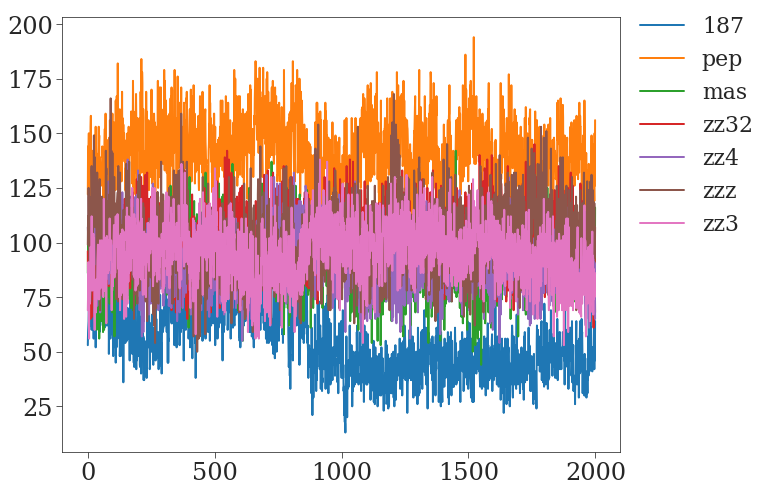

In [6]:
fig, ax = plt.subplots(figsize=(10, 8)) 

for index, row in df.iterrows(): 
    ax.plot(row['contact'], label=row['system'])
ax.legend(bbox_to_anchor=(1.0, 1.05))

## number of residues contacting with ligand

In [7]:
def prot_lig_contact_res(pdb_file, traj_file, cutoff=4):
    """
    Calculate the contact between protein and ligand, 
    assuming ligand name is UNK
    """
    mda_traj = mda.Universe(pdb_file, traj_file)

    protein_noH = mda_traj.select_atoms('protein and not name H*')
    ligand = mda_traj.select_atoms('not protein and not resname WAT and not name Na+ and not name H*') 
    # handling peptide case 
    if ligand.n_atoms == 0: 
        n_oxt = np.where(protein_noH.atoms.names == 'OXT')[0]
        ligand = protein_noH.atoms[n_oxt[0]+1:]
        protein_noH = protein_noH.atoms[:n_oxt[0]+1]
    contact_prof = []
    for _ in mda_traj.trajectory:
        distance_pro_lig = distances.distance_array(
                            protein_noH.positions, 
                            ligand.positions, 
                            box=protein_noH.dimensions)
        contact_num = np.sum(distance_pro_lig < cutoff, axis=1) 
        atom_ids = np.where(contact_num != 0)[0] 
        residues = protein_noH.atoms[atom_ids].residues
        contact_prof.append(len(residues))

    return contact_prof

In [8]:
contact_profs = []
for run in runs: 
    label = os.path.basename(run).split('_')[-1] 
    if label == 'protein': 
        continue
    pdb_file = run + '/comp.pdb'
    dcd_file = run + '/output.dcd' 
    contact_prof = prot_lig_contact_res(pdb_file, dcd_file) 
    
    contact_profs.append({'system': label, 'contact': contact_prof})

In [9]:
df = pd.DataFrame(contact_profs)
df

,system,contact
0,187,"[12, 14, 15, 14, 13, 16, 13, 14, 13, 14, 13, 1..."
1,pep,"[22, 28, 25, 26, 25, 27, 23, 26, 26, 26, 27, 2..."
2,mas,"[17, 17, 17, 16, 18, 17, 18, 14, 15, 12, 17, 1..."
3,zz32,"[20, 20, 19, 19, 20, 18, 17, 18, 17, 18, 17, 1..."
4,zz4,"[18, 19, 21, 19, 21, 23, 20, 18, 21, 21, 20, 2..."
5,zzz,"[21, 22, 21, 21, 21, 17, 22, 18, 20, 21, 16, 1..."
6,zz3,"[16, 21, 21, 16, 18, 15, 18, 19, 19, 17, 18, 1..."


Text(0, 0.5, 'Number of binding AA')

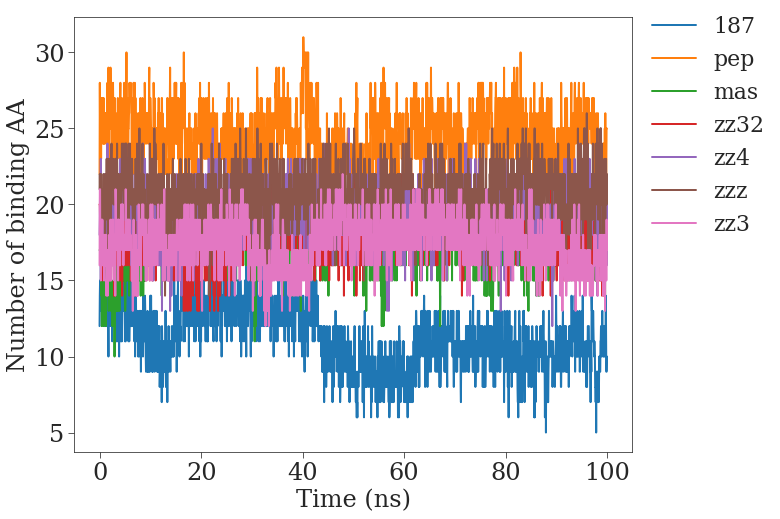

In [14]:
fig, ax = plt.subplots(figsize=(10, 8)) 

for index, row in df.iterrows(): 
    ax.plot(np.arange(len(row['contact']))/20, row['contact'], label=row['system'])
ax.legend(bbox_to_anchor=(1.0, 1.05))
ax.set_xlabel("Time (ns)")
ax.set_ylabel(r"Number of binding AA")

2